Loading the dataset

In [1]:
import os
import numpy as np
from google.colab import drive

## Google Drive
drive.mount('/content/drive')

root_folder = '/content/drive/My Drive/Flow_Structure_Clustering'
preprocessed_data_folder = os.path.join(root_folder, 'Preprocessed_Data')
file_path = os.path.join(preprocessed_data_folder, 'Dat_phi.npy')
Dat_phi = np.load(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocessing

In [2]:
t1 = 0
t2 = 1500
t_len = 1500
time = np.arange(0, 1500)
t_cal = time[t1:t2]
t_skip = 1
r_skip = 3

dat_phi = Dat_phi[1:, :, :][::r_skip, :, ::t_skip]
r_len = dat_phi.shape[0]
th_len = dat_phi.shape[1]
r_arr = np.linspace(1/r_len, 1, r_len)
th_arr = np.linspace(0, (2 * np.pi)-((2*np.pi)/th_len), th_len)
theta_arr = th_arr/(2 * np.pi)

In [3]:
from scipy.interpolate import griddata

## Cartesian -> Polar coordinates
X = np.zeros((r_len, th_len))
Y = np.zeros((r_len, th_len))
for b in range(r_len):
  for c in range(th_len):
    X[b, c] = r_arr[b] * np.cos(th_arr[c])
    Y[b, c] = r_arr[b] * np.sin(th_arr[c])

x_len = y_len = 64
x_arr = np.linspace(-1, 1, x_len) #x_min:x_max
y_arr = np.linspace(-1, 1, y_len) #y_min:y_max
Xq, Yq = np.meshgrid(x_arr, y_arr)

phi_xy = np.zeros((x_len, y_len, t_len))
for bt in range(t_len):
  data = griddata((X.flatten(), Y.flatten()), np.squeeze(dat_phi[:, :, bt]).flatten(), (Xq, Yq), method = "linear")
  data[np.isnan(data)] = 0

  for bx in range(x_len):
    for by in range(y_len):
      if np.sqrt((Xq[1, bx]**2) + (Yq[by, 1]**2)) <= 1 :
        phi_xy[bx, by, bt] = data[bx, by]
      else:
        phi_xy[bx, by, bt] = 0

In [4]:
## multi-field SVD
phi_1d = phi_xy.reshape(y_len*x_len, t_len)
u_1d, s, vt = np.linalg.svd(phi_1d, full_matrices = False)
print(u_1d.shape, s.shape, vt.shape)

(4096, 1500) (1500,) (1500, 1500)


In [5]:
m_len = 30
m_arr = np.arange(m_len)

dt = time[2] - time[1]
Vt_n = np.zeros((m_len, t_len))
Vt_vr = np.zeros((m_len, t_len))
S = np.zeros((m_len))
for m in range(m_len):
  A = np.sqrt(np.sum(vt[m, :] * vt[m, :]) * dt)
  Vt_n[m, :] = vt[m, :t_len] / A
  S[m] = s[m] * A

U = np.zeros((x_len, y_len, m_len))
for m in range(m_len):
  U[:, :, m] = (u_1d[:, m] * S[m]).reshape(x_len, y_len)

## SVD modes
N_UVt = np.zeros((x_len, y_len, t_len, m_len))
for m in range(m_len):
  for t in range(t_len):
    n = u_1d[:, m] * S[m] * Vt_n[m, t]
    N_UVt[:, :, t, m] = n.reshape(x_len, y_len)

Classification of modes into zonal flow and turbulence

In [6]:
## Granularity
L = 64

from skimage.transform import rotate

error_vector = np.zeros(m_len)
for i in range(m_len):
    Psi = u_1d[:, i].reshape(x_len, y_len)
    error = 0
    for l in range(L):
        rotated_Psi = rotate(Psi, 360 * (l / L), resize=False, mode='edge')
        error += np.sqrt(np.mean((Psi - rotated_Psi) ** 2))
    error_vector[i] = error

## Zonal flows
GroupA = np.where(error_vector < 0.5)[0]
GroupA = GroupA[GroupA>0]

## Turbulence
GroupB = np.array(list(set(range(m_len)) - set(GroupA)))
GroupB = GroupB[GroupB>0]

Decomposition of turbulence into finer modes

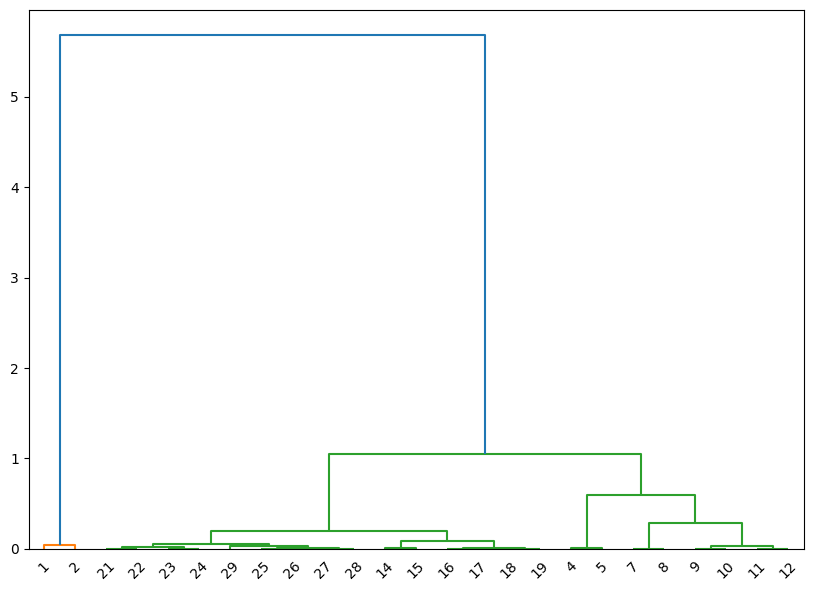

In [12]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

## Compute dissimilarity using singular values
dsm = np.abs(s[range(m_len), np.newaxis] - s[range(m_len)])

## Standardize dissimilarities for GroupA and GroupB
tmp = dsm[np.ix_(GroupA, GroupA)]; DA = tmp/np.std(tmp)
tmp = dsm[np.ix_(GroupB, GroupB)]; DB = tmp/np.std(tmp)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import set_link_color_palette

## Perform hierarchical clustering
method="ward"

condensed_DA = squareform(DA)
condensed_DB = squareform(DB)
linkage_A = linkage(condensed_DA, method)
linkage_B = linkage(condensed_DB, method)

## Plot dendrogram for GroupB (Turbulence)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
dendrogram(linkage_B, labels=GroupB)
plt.show()

Visualization of the finer modes

In [8]:
## Groups detected by the hierarchical clustering

Group0 = [0] #background
GroupAll = range(m_len)
GroupA = GroupA
GroupB0 = [1,2]
GroupB1 = [4,5,7,8,9,10,11,12] ## detected by hierarchical clustering
GroupB2 = np.array(list(set(GroupB)-set(GroupB0)-set(GroupB1)))
GroupB12 =  np.array(list(set(GroupB)-set(GroupB0)))

In [9]:
## A function that generates images of N_UVt for t=0,1,2,....,t_len-1

import os
import matplotlib.pyplot as plt
import imageio

def save_N_UVt_images(N_UVt, Group, t_len, folder_name):
    # where to save
    save_folder = os.path.join(root_folder, folder_name)

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    total_N_UVt = np.sum(N_UVt[:,:,:,Group], axis=-1)
    min_val = np.min(total_N_UVt)
    max_val = np.max(total_N_UVt)

    for t in range(t_len + 1):
        plt.imshow(total_N_UVt[:,:,t], vmin=min_val, vmax=max_val, cmap='CMRmap')

        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        save_path = os.path.join(save_folder, f't_{t}.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)

        plt.close()

    gif_path = os.path.join(root_folder, f'{folder_name}.gif')
    images = []

    for t in range(t_len + 1):
        image_path = os.path.join(save_folder, f't_{t}.png')
        images.append(imageio.imread(image_path))

    imageio.mimsave(gif_path, images, duration=0.1, loop=0)

In [13]:
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import gc  # Import garbage collection

def save_N_UVt_images(N_UVt, Group, t_len, folder_name, title_color='black'):
    # where to save
    save_folder = os.path.join(root_folder, folder_name)

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    total_N_UVt = np.sum(N_UVt[:,:,:,Group], axis=-1)
    min_val = np.min(total_N_UVt)
    max_val = np.max(total_N_UVt)

    for t in range(t_len + 1):
        # Plot the image
        plt.imshow(total_N_UVt[:,:,t], vmin=min_val, vmax=max_val, cmap='CMRmap')

        # Hide the axes
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        # Remove margins
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        # Add the 't=...' text at the top-left in the specified color
        plt.text(0.05, 0.95, f't={t}', color=title_color, fontsize=24,
                 horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)

        # Save the image
        save_path = os.path.join(save_folder, f't_{t}.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)

        # Close the figure to free memory
        plt.close()

        # Explicitly delete unused objects
        del save_path

        # Invoke garbage collector to free memory
        gc.collect()

    # GIF creation process
    gif_path = os.path.join(root_folder, f'{folder_name}.gif')
    images = []

    for t in range(t_len + 1):
        image_path = os.path.join(save_folder, f't_{t}.png')
        images.append(imageio.imread(image_path))

    # Save GIF with 100ms duration per frame and infinite loop
    imageio.mimsave(gif_path, images, duration=0.1, loop=0)

    # Free memory by clearing the image list
    del images
    gc.collect()  # Force garbage collection

    print(f"GIF saved at {gif_path}")

In [14]:
t_max = 200 # increase this number
save_N_UVt_images(N_UVt, GroupAll, t_max, 'GroupAll', title_color='black')
save_N_UVt_images(N_UVt, Group0, t_max, 'Group0', title_color='black')
save_N_UVt_images(N_UVt, GroupA, t_max, 'GroupA', title_color='white')
save_N_UVt_images(N_UVt, GroupB, t_max, 'GroupB', title_color='white')
save_N_UVt_images(N_UVt, GroupB0, t_max, 'GroupB0', title_color='white')
save_N_UVt_images(N_UVt, GroupB1, t_max, 'GroupB1', title_color='white')
save_N_UVt_images(N_UVt, GroupB2, t_max, 'GroupB2', title_color='white')
save_N_UVt_images(N_UVt, GroupB12, t_max, 'GroupB12', title_color='white')

GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupAll.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/Group0.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupA.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupB.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupB0.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupB1.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupB2.gif
GIF saved at /content/drive/My Drive/Flow_Structure_Clustering/GroupB12.gif
